In [16]:
import os
import pickle
import numpy as np
import pandas as pd
from os import path
import seaborn as sns
from scipy import sparse, io
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from scipy.sparse import csr_matrix, hstack
from dotenv import load_dotenv, find_dotenv
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.metrics import make_scorer, f1_score, confusion_matrix
%matplotlib notebook

dotenv_path = find_dotenv()
load_dotenv(dotenv_path)


RAW_DATA_DIR = os.environ.get("RAW_DATA_DIR")
FEATURES_DATA_DIR = os.environ.get("FEATURES_DIR")
MODELS_DIR = os.environ.get("MODELS_DIR")



In [17]:
data = io.mmread(path.join(FEATURES_DATA_DIR, 'sparse_train_p_al_d')).tocsr()
gatrain = pd.read_csv(os.path.join(RAW_DATA_DIR,'gender_age_train.csv'),
                      index_col='device_id')
labels = gatrain['group']
targetencoder = LabelEncoder().fit(labels)
y_labels = targetencoder.transform(labels)
nclasses = len(targetencoder.classes_)

X, X_dev, y, y_dev = train_test_split(data,
                                      y_labels,
                                      test_size=0.20,
                                      random_state=0)



In [18]:
clf = LogisticRegression(C=0.03, multi_class='multinomial', solver='newton-cg', n_jobs=4)
clf.fit(X, y)

pred_proba = clf.predict_proba(X_dev)



<IPython.core.display.Javascript object>


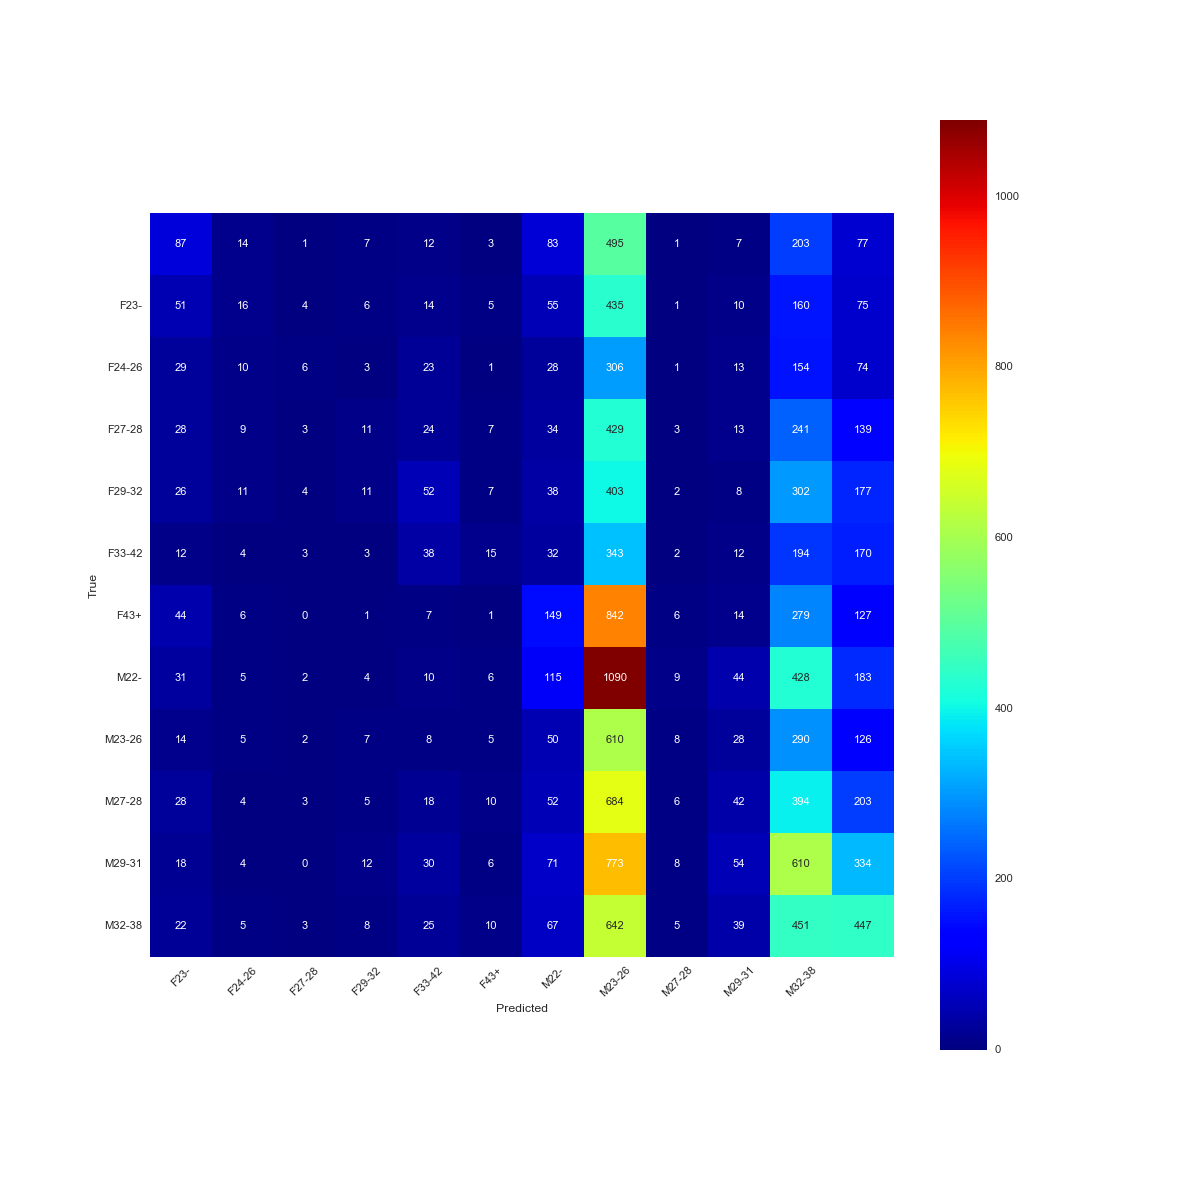

In [19]:
pred = pd.DataFrame(pred_proba).idxmax(axis=1)
pred = pred.reset_index()
pred = pred.rename(columns={0:'encoded'}).drop(['index'],1)
pred['de-encoded'] = targetencoder.inverse_transform(pred['encoded'])
pred['baseline'] = pd.Series(7, index=np.arange(len(pred)))
f1_score(y_dev, pred['encoded'], average='weighted')

f1_score(y_dev, pred['baseline'], average='weighted')

y_dev = pd.DataFrame(y_dev).reset_index().drop(['index'],1)
pred = pred.rename(columns={0:'encoded'})
y_dev['de-encoded'] = targetencoder.inverse_transform(y_dev[0])

cm = confusion_matrix(y_dev['de-encoded'], pred['de-encoded'])
labels = targetencoder.inverse_transform(range(11))
with sns.axes_style('white'):
    plt.figure(figsize=(15,15))
    ax = sns.heatmap(cm, square=True, xticklabels=labels, yticklabels=labels, 
                     annot=True, cmap=plt.cm.jet, fmt='.00f')
    plt.xticks(rotation=45) 
    plt.yticks(rotation=0) 
    plt.xlabel('Predicted')
    plt.ylabel('True')

<IPython.core.display.Javascript object>


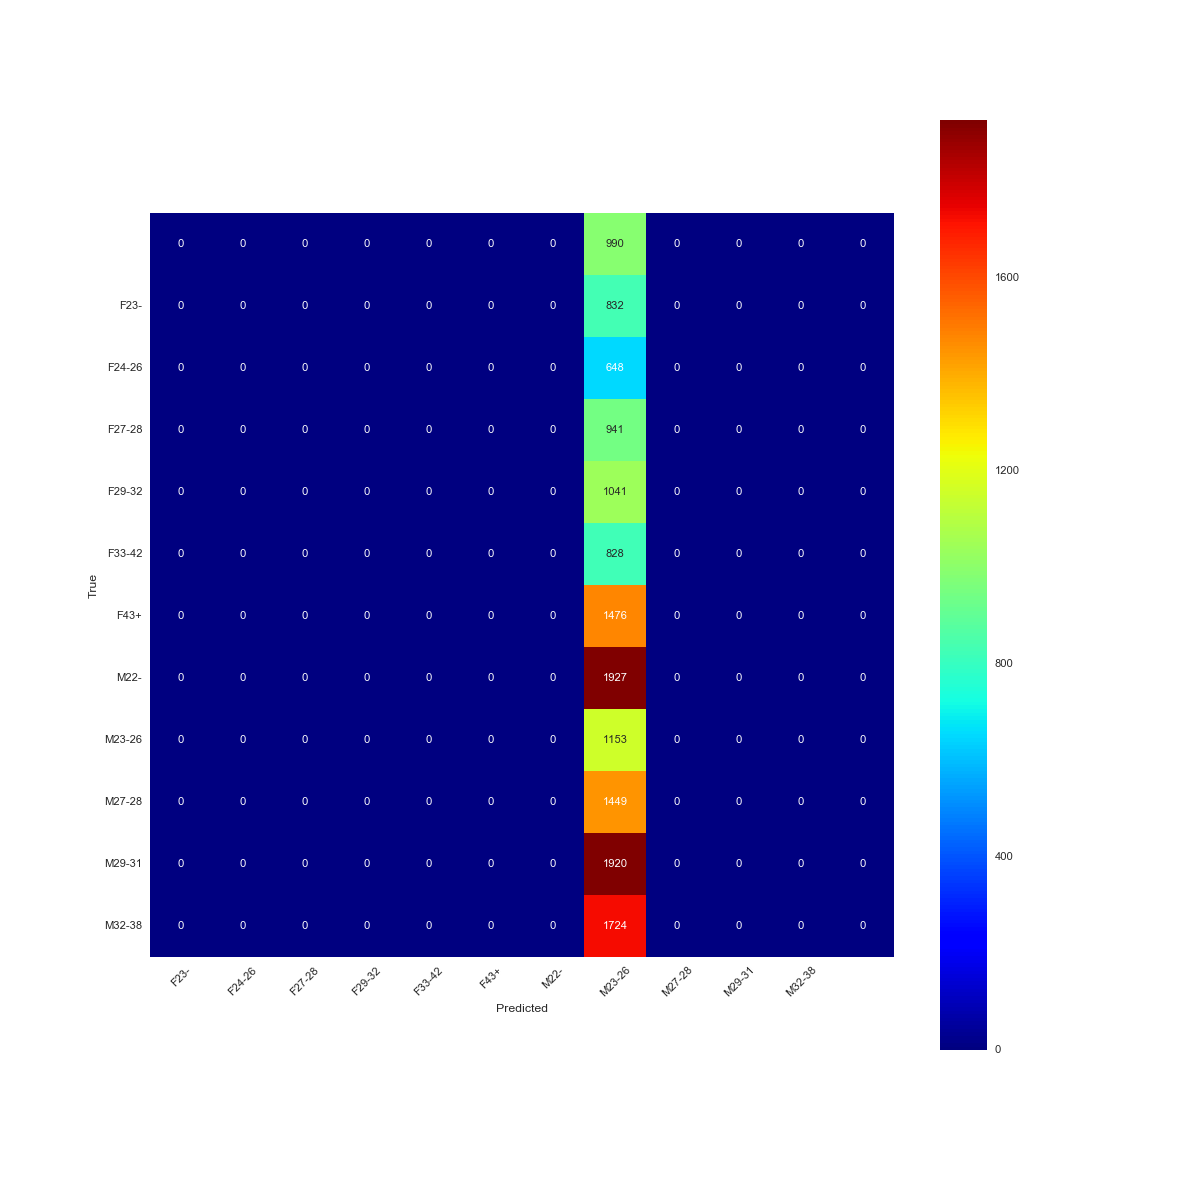

In [20]:
pred['base_de-encoded'] = targetencoder.inverse_transform(pred['baseline'])

cm = confusion_matrix(y_dev['de-encoded'], pred['base_de-encoded'])
labels = targetencoder.inverse_transform(range(11))
with sns.axes_style('white'):
    plt.figure(figsize=(15,15))
    ax = sns.heatmap(cm, square=True, xticklabels=labels, yticklabels=labels, 
                     annot=True, cmap=plt.cm.jet, fmt='.00f')
    plt.xticks(rotation=45) 
    plt.yticks(rotation=0) 
    plt.xlabel('Predicted')
    plt.ylabel('True')